# Double Jet

With various grid sizes

In [1]:
from gpuocean.SWEsimulators import ModelErrorKL, CDKLM16
from gpuocean.utils import Common, IPythonMagic

from importlib import reload

import numpy as np
import copy
import pycuda.driver as cuda
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

plt.rcParams["image.origin"] = "lower"


In [2]:
%cuda_context_handler gpu_ctx

In [3]:
gpu_stream = cuda.Stream()

In [4]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))

Get initial arguments from class

In [5]:
from gpuocean.utils import DoubleJetCase

In [6]:
doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=512, nx=1024)
doubleJetCase_args, doubleJetCase_init, _ = doubleJetCase.getInitConditions()

## Truth

In [7]:
from gpuocean.utils import Observation, DrifterPlotHelper

In [8]:
truth_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetTruth/2023-11-02T09_33_29"

true_trajectories = Observation.Observation(domain_size_x=doubleJetCase_args["nx"]*doubleJetCase_args["dx"],
                                            domain_size_y=doubleJetCase_args["ny"]*doubleJetCase_args["dy"], 
                                            nx=doubleJetCase_args["nx"], ny=doubleJetCase_args["ny"])

true_trajectories.read_pickle(os.path.join(truth_path, "truth_trajectories.pickle"))

In [9]:
true_trajectories.get_num_drifters()

100

## Ensemble drifter

In [10]:
slda_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetSLDA/2023-11-10T11_44_24"

slda_drifter_path = os.path.join(slda_path, "sldrifters_60")

slda_trajectories = []
for f in os.listdir(slda_drifter_path):
    if f.startswith("sl"):
        trajectory = Observation.Observation(domain_size_x=doubleJetCase_args["nx"]*doubleJetCase_args["dx"],
                                                domain_size_y=doubleJetCase_args["ny"]*doubleJetCase_args["dy"], 
                                                nx=doubleJetCase_args["nx"], ny=doubleJetCase_args["ny"])

        trajectory.read_pickle(os.path.join(slda_drifter_path,f))
        
        slda_trajectories.append(trajectory)



slda_trajectories2 = []
for f in os.listdir(slda_drifter_path):
    if f.startswith("ml"):
        trajectory = Observation.Observation(domain_size_x=doubleJetCase_args["nx"]*doubleJetCase_args["dx"],
                                                domain_size_y=doubleJetCase_args["ny"]*doubleJetCase_args["dy"], 
                                                nx=doubleJetCase_args["nx"], ny=doubleJetCase_args["ny"])

        trajectory.read_pickle(os.path.join(slda_drifter_path,f))
        
        slda_trajectories2.append(trajectory)

In [11]:
mlda_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetMLDA/2023-11-09T18_07_14"
mlda_drifter_path = os.path.join(mlda_path, "mldrifters_60")

# mlda_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetMLDA/2023-11-08T15_45_28"
# mlda_drifter_path = os.path.join(mlda_path, "mldrifters")

mlda_trajectories = []
for f in os.listdir(mlda_drifter_path):
    trajectory = Observation.Observation(domain_size_x=doubleJetCase_args["nx"]*doubleJetCase_args["dx"],
                                            domain_size_y=doubleJetCase_args["ny"]*doubleJetCase_args["dy"], 
                                            nx=doubleJetCase_args["nx"], ny=doubleJetCase_args["ny"])

    trajectory.read_pickle(os.path.join(mlda_drifter_path,f))
    
    mlda_trajectories.append(trajectory)

## Drifters

Drifter Calibration and Spread

In [12]:
from scipy.spatial.distance import cdist

In [13]:
ensemble_obs = slda_trajectories

def drifter_statistics(ensemble_obs, true_trajectories):

    width  = ensemble_obs[0].domain_size_x/1000
    height = ensemble_obs[0].domain_size_y/1000

    def center_around_true_postion(true_position, last_positions, width, height):
        centered_positions = last_positions - true_position
        centered_positions[:,0][centered_positions[:,0] < -0.5*width ] = centered_positions[:,0][centered_positions[:,0] < -0.5*width ] + width
        centered_positions[:,0][centered_positions[:,0] > +0.5*width ] = centered_positions[:,0][centered_positions[:,0] > +0.5*width ] - width
        centered_positions[:,1][centered_positions[:,1] < -0.5*height] = centered_positions[:,1][centered_positions[:,1] < -0.5*height] + height
        centered_positions[:,1][centered_positions[:,1] > +0.5*height] = centered_positions[:,1][centered_positions[:,1] > +0.5*height] - height

        return centered_positions

    drifter_rmses = np.zeros(72)
    drifter_stds  = np.zeros(72)

    for t_idx in range(1,72):
        drifter_t = true_trajectories.obs_df["time"].iloc[4*t_idx]

        rmse_t = 0.0
        std_t  = 0.0

        for drifter_id in range(100):
            true_position = true_trajectories.get_drifter_path(drifter_id, 0, drifter_t)[-1][-1]

            ## Get last postions
            numTrajectories = len(ensemble_obs)

            last_positions = np.zeros((numTrajectories,2))
            for d in range(numTrajectories):
                last_positions[d] = ensemble_obs[d].get_drifter_path(drifter_id, 0, drifter_t)[-1][-1]
            last_positions = last_positions[~np.isnan(last_positions)].reshape(-1,2)

            centered_positions = center_around_true_postion(true_position, last_positions, width, height)

            rmse_t += 1/100 * np.sqrt(np.sum(np.mean(centered_positions, axis=0)**2)) # truth is at [0,0] after centering
            std_t  += 1/100 * np.sqrt(np.sum(np.std(centered_positions, axis=0, ddof=1)**2))

        drifter_rmses[t_idx] = rmse_t
        drifter_stds [t_idx] = std_t

    return drifter_rmses, drifter_stds

In [14]:
slda_drifter_stats = drifter_statistics(slda_trajectories, true_trajectories)
slda2_drifter_stats = drifter_statistics(slda_trajectories2[0:50], true_trajectories)
mlda_drifter_stats = drifter_statistics(mlda_trajectories[0:50], true_trajectories)

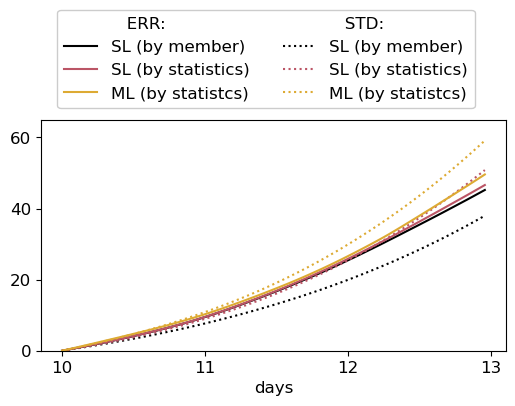

In [19]:
c0 = (0,0,0)
c3 = (0, 68/255, 136/255)
c1 = (187/255, 85/255, 102/255)
c2= (221/255, 170/255, 51/255)


fig, ax = plt.subplots(1,1, figsize=(6, 3))

ax.plot(slda_drifter_stats[0], c=c0, label = "SL (by member)")
ax.plot(slda_drifter_stats[1], c=c0, ls="dotted", label = "SL (by member)")

ax.plot(slda2_drifter_stats[0], c=c1, label = "SL (by statistics)")
ax.plot(slda2_drifter_stats[1], c=c1, ls="dotted", label = "SL (by statistics)")

ax.plot(mlda_drifter_stats[0], c=c2, label = "ML (by statistcs)")
ax.plot(mlda_drifter_stats[1], c=c2, ls="dotted", label = "ML (by statistcs)")

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

ax.set_xticks([0,24,48,72])
ax.set_xticklabels([10, 11, 12, 13])
ax.set_xlabel("days", fontsize=12)

ax.set_ylim((0,65))


h, l = ax.get_legend_handles_labels()
ph = [plt.plot([],marker="", ls="")[0]]*2

handles = ph[:1] + h[::2] + ph[1:] + h[1::2]
labels = ["   ERR: "] + l[::2] + ["   STD:"] + l[1::2]

leg = fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5,1.275), ncol=2, framealpha=1.0, fontsize=12)

plt.savefig("DoubleJet-DA-PostProcessing-DriftersERR4paper.pdf", bbox_inches="tight", dpi=300)


In [16]:
1+1

2